# ASSIGNMENT #2: Script to plot temperature trends

by Daniel Horton, Feb 2017; mod to Python: Irene Crisologo, June 2019

daniel.horton@northwestern.edu

**Objectives:**

Use the WACCM netCDF file to 

(1) create a time series plot of latitude-weighted global average **monthly** temperatures from 2006-2099 and 

(2) create a time series plot of latitude-weighted global average **annual** temperature anomalies from 2006-2099. Use 2006-2035 as your baseline.

### Import libraries

In this exercise, we need the following libraries:

* `xarray` for reading the data file
* `matplotlib` for plotting
* `numpy` for numerical functions
* `math` for mathematical operations
* `cftime` for handling the CF time format

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import math
import cftime

/home/iac6311/.conda/envs/tutorial/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/iac6311/.conda/envs/tutorial/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### Define functions

The global averages must be weighted by latitude. At the moment, `xarray` does not have a built-in function for weighted averaging ([though this feature seems to be close to being included...](https://github.com/pydata/xarray/issues/422)), so here is a function [created/suggested by an xarray user](https://github.com/pydata/xarray/issues/2713) for weighted averaging...

In [3]:
def weighted_mean(data_da, dim, weights):
    r"""Computes the weighted mean.

    We can only do the actual weighted mean over the dimensions that
    ``data_da`` and ``weights`` share, so for dimensions in ``dim`` that aren't
    included in ``weights`` we must take the unweighted mean.

    This functions skips NaNs, i.e. Data points that are NaN have corresponding
    NaN weights.

    Args:
        data_da (xarray.DataArray):
            Data to compute a weighted mean for.
        dim (str | list[str]):
            dimension(s) of the dataarray to reduce over
        weights (xarray.DataArray):
            a 1-D dataarray the same length as the weighted dim, with dimension
            name equal to that of the weighted dim. Must be nonnegative.
    Returns:
        (xarray.DataArray):
            The mean over the given dimension. So it will contain all
            dimensions of the input that are not in ``dim``.
    Raises:
        (IndexError):
            If ``weights.dims`` is not a subset of ``dim``.
        (ValueError):
            If ``weights`` has values that are negative or infinite.
    """
    if isinstance(dim, str):
        dim = [dim]
    else:
        dim = list(dim)

    if not set(weights.dims) <= set(dim):
        dim_err_msg = (
            "`weights.dims` must be a subset of `dim`. {} are dimensions in "
            "`weights`, but not in `dim`."
        ).format(set(weights.dims) - set(dim))
        raise IndexError(dim_err_msg)
    else:
        pass  # `weights.dims` is a subset of `dim`

    if (weights < 0).any() or xr.ufuncs.isinf(weights).any():
        negative_weight_err_msg = "Weight must be nonnegative and finite"
        raise ValueError(negative_weight_err_msg)
    else:
        pass  # `weights` are nonnegative

    weight_dims = [
        weight_dim for weight_dim in dim if weight_dim in weights.dims
    ]

    if np.isnan(data_da).any():
        expanded_weights, _ = xr.broadcast(weights, data_da)
        weights_with_nans = expanded_weights.where(~np.isnan(data_da))
    else:
        weights_with_nans = weights

    mean_da = ((data_da * weights_with_nans).sum(weight_dims, skipna=True)
               / weights_with_nans.sum(weight_dims))
    other_dims = list(set(dim) - set(weight_dims))
    return mean_da.mean(other_dims, skipna=True)

### Reading the file

Set the filename.

In [4]:
fname = '/projects/b1045/cmip/CMIP5/NCL_Practice/tas_Amon_CESM1-WACCM_rcp85_r2i1p1_200601-209912.nc'

Use `xarray` to read the file. 

In [5]:
DS=xr.open_dataset(fname)

In [6]:
print(DS)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 144, time: 1128)
Coordinates:
  * time       (time) object 2006-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes:
    institution:                  NSF/DOE NCAR (National Center for Atmospher...
    institute_id:                 NSF-DOE-NCAR
    experiment_id:                rcp85
    source:                       CESM1-WACCM
    model_id:                     CESM1-WACCM
    forcing:                      Sl GHG SS Ds SA BC MD OC Oz AA
    parent_experiment_id:         historical
    parent_experiment_rip:        r2i1p1
    branch_time:      

## Task 1: Time series of global monthly averages

Select the time period of interest.

In [7]:
data_2006_2099=DS.sel(time=slice('2006-01-01','2099-12-31')) # 94 years

Assign the contents of the netcdf file to variables.

In [8]:
lat = data_2006_2099.lat # latitude
lon = data_2006_2099.lon # longitude
tas = data_2006_2099.tas # near-surface air temperature

Calculate the weights according to latitude. There are multiple ways to do this (see [here](https://www.ncl.ucar.edu/Document/Functions/Built-in/wgt_areaave.shtml)). In this example, we use the cosine of latitudes.

In [9]:
rad  = 4.*math.atan(1.)/180.
weights   = np.cos(lat*rad)

Now we use the function defined above to calculate the weighted mean over the latitude, passing the correct parameters.

In [10]:
wmean_lat = weighted_mean(data_2006_2099.tas, dim='lat', weights=weights)

Since we want a single average value for the year, we also average over the longitudes. This time it does not have to be weighted.

In [11]:
wmean = wmean_lat.mean(dim='lon')

### Plotting

We want to plot the monthly mean temperatures over time. The data is already in monthly intervals, so we just need to get the data values from the `wmean` DataArray and plot that agains the time variable.

Text(0.0, 1.0, 'Global Monthly Mean Temperatures')

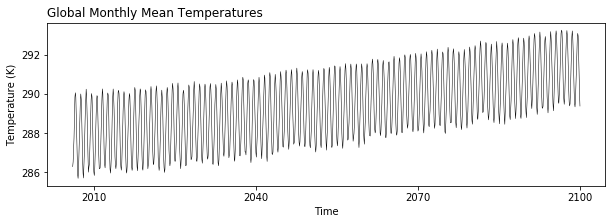

In [12]:
plt.figure(figsize=(10,3))
plt.plot(wmean.time, wmean.data, linestyle='-', color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Global Monthly Mean Temperatures', loc='left')

## Task 2: Plot the global average annual temperature anomalies

We already have the latitude-weighted monthly mean above, now we just need to get the annual average. We can do this by grouping the monthly data to yearly, using `groupby`.

In [13]:
annual_wmean = wmean.groupby('time.year').mean(dim='time')

We want to get the temperature anomalies, using 2006-2035 as the baseline.

To do this, we get the timeslice for the baseline, then take the average of that over time.

In [14]:
baseline = wmean.sel(time=slice('2006-01-01','2035-12-31')).mean(dim='time')

This should give us a single value of the baseline temperature.

In [15]:
print(baseline)

<xarray.DataArray ()>
array(288.227638)
Coordinates:
    height   float64 2.0


We then subtract the baseline from the annual weighted mean, to get the anomaly.

In [19]:
anomaly = annual_wmean - baseline

### Plotting

Text(0.0, 1.0, 'Global Annual Temperature Anomaly')

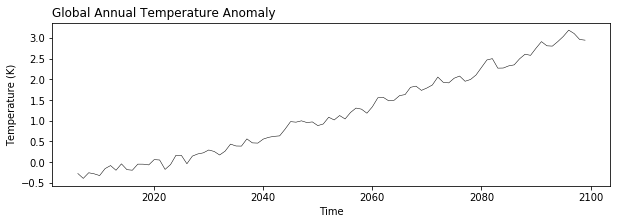

In [20]:
plt.figure(figsize=(10,3))
plt.plot(anomaly.year, anomaly.data, linestyle='-', color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Global Annual Temperature Anomaly', loc='left')

### Bonus! Plotting the two plots together

The time variable of the monthly mean is in a certain type (`cftime.DatetimeNoLeap`), while after doing the annual average the time variable in the `anomaly` variable then becomes an integer array. In order to make sure the two plots wil align together, we need to be able to set the limits of the axis.

In [24]:
print(wmean.time)

<xarray.DataArray 'time' (time: 1128)>
array([cftime.DatetimeNoLeap(2006, 1, 16, 12, 0, 0, 0, 5, 16),
       cftime.DatetimeNoLeap(2006, 2, 15, 0, 0, 0, 0, 0, 46),
       cftime.DatetimeNoLeap(2006, 3, 16, 12, 0, 0, 0, 1, 75), ...,
       cftime.DatetimeNoLeap(2099, 10, 16, 12, 0, 0, 0, 0, 289),
       cftime.DatetimeNoLeap(2099, 11, 16, 0, 0, 0, 0, 3, 320),
       cftime.DatetimeNoLeap(2099, 12, 16, 12, 0, 0, 0, 5, 350)], dtype=object)
Coordinates:
  * time     (time) object 2006-01-16 12:00:00 ... 2099-12-16 12:00:00
    height   float64 2.0
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time


In [25]:
print(anomaly.year)

<xarray.DataArray 'year' (year: 94)>
array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053,
       2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065,
       2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077,
       2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089,
       2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])
Coordinates:
    height   float64 2.0
  * year     (year) int64 2006 2007 2008 2009 2010 ... 2095 2096 2097 2098 2099


Convert the time data type from `cftime.DatatimeNoLeap` to a python datetime object, for easier handling of datetime types.

In [26]:
wmean_time = wmean.indexes['time'].to_datetimeindex()

/home/iac6311/.conda/envs/tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


Make the plots!

/home/iac6311/.conda/envs/tutorial/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


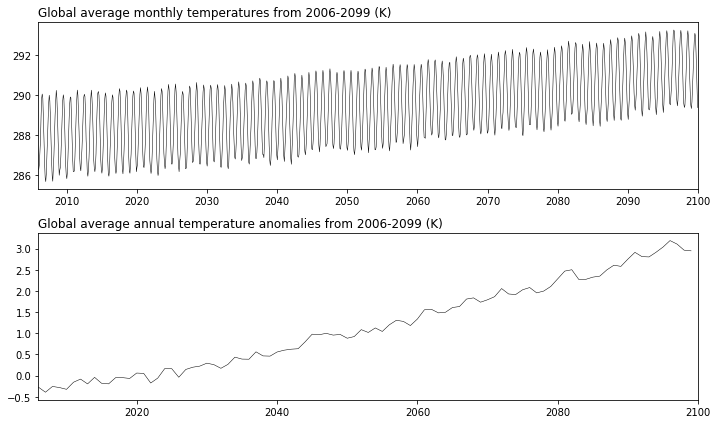

In [27]:
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(10,6))

ax1.plot(wmean_time, wmean.data, linestyle='-', color='black', linewidth=0.5)
ax1.set_xlim('2006-01-01','2100-01-01')
ax2.plot(anomaly.year, anomaly.data, linestyle='-', color='black', linewidth=0.5)
ax2.set_xlim(2006,2100)
ax1.set_title('Global average monthly temperatures from 2006-2099 (K)', loc='left')
ax2.set_title('Global average annual temperature anomalies from 2006-2099 (K)', loc='left')

plt.tight_layout()

To look at the actual numbers, print the data values.

In [28]:
print(anomaly.data)

[-0.27398833 -0.3928596  -0.25660996 -0.28277124 -0.32445951 -0.156333
 -0.08287064 -0.19662883 -0.04152032 -0.18185994 -0.19525019 -0.04827331
 -0.04900845 -0.06719504  0.06025024  0.05189544 -0.17560422 -0.05903959
  0.16658576  0.16169586 -0.03929155  0.14550122  0.19819768  0.22433814
  0.29353968  0.25825732  0.17226771  0.26498404  0.43586305  0.39018759
  0.38731491  0.56183486  0.46526567  0.45995635  0.5568897   0.60009746
  0.62371891  0.63457894  0.79747911  0.97852875  0.96573386  0.99849351
  0.95655332  0.97209901  0.88290947  0.92237166  1.08554578  1.0192119
  1.12626252  1.04311037  1.20040475  1.30664864  1.28076551  1.18238045
  1.33696536  1.55468798  1.56587737  1.4817337   1.49645861  1.60866144
  1.63195482  1.80867906  1.83648361  1.73430737  1.79201439  1.86439335
  2.05659861  1.92860164  1.91509719  2.02837711  2.08056046  1.95446325
  1.99747418  2.10530647  2.28730364  2.46915976  2.50135556  2.27167331
  2.27430155  2.32634983  2.35092335  2.49836754  2.60

Some references used:

* https://github.com/SciTools/nc-time-axis/pull/42
* https://github.com/Unidata/cftime/issues/111
* https://github.com/pydata/xarray/issues/2713
* http://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html
* http://xarray.pydata.org/en/stable/examples/monthly-means.html